In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
from shapely.geometry import LineString
from shapely import affinity

# Make beam:

In [2]:
def make_beam(length, location=(0,0)):
    b0 = LineString([location, (length, 0)])
    return b0

def evaluate_beam_rotation(beam, rotated_beam):
    x0,y0 = beam.coords.xy
    x1,y1 = rotated_beam.coords.xy
    
    fig,ax=plt.subplots()
    ax.plot(x0,y0, label="beam", color="blue")
    ax.plot(x1,y1, label="rotated beam", color="green", linestyle=":")
    plt.xlim(0,beam.length+1)
    plt.ylim(0,beam.length+1)
    plt.close()
    return fig

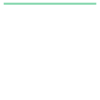

In [3]:
make_beam(length=10)

# Rotate the beam

In [4]:
b0 = make_beam(length = 10) ## Beam 1
b1 = affinity.rotate(b0, angle=15, origin=(0,0)) ## beam2: rotated beam

x0, y0 = np.array(b0.coords.xy)
x1,y1 = np.array(b1.coords.xy)
print(x1,y1)

[0.         9.65925826] [0.         2.58819045]


# Plotting the rotate beams (all together)

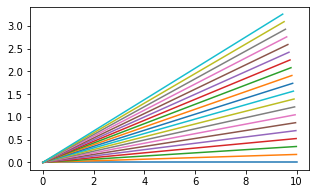

In [5]:
fig, ax = plt.subplots(figsize=(5,3))
plt.close()

angles = np.arange(0,20,1)
b0 = make_beam(length = 10)
for angle in angles:
    b1 = affinity.rotate(b0, angle=angle, origin=(0,0))
    x1,y1 = np.array(b1.coords.xy)
    ax.plot(x1,y1)
    
fig

# Animate the beam rotation in 2D plane

In [6]:
## User inputs
beam_length = 10
angles = np.hstack((np.arange(0,20,1), np.arange(20,0,-1)))

fig, ax = plt.subplots(figsize=(10,6))
## Animation functions

def init():
    
    b0 = make_beam(length = beam_length)
    x0, y0 = np.array(b0.coords.xy)
    beam = ax.plot(x0,y0, color='blue')
    
    ax.set_xlabel("x")
    ax.set_label("y")
    ax.grid()

def update(i):
    i = int(i)
    angle = angles[i] ## Current angle
    b1 = affinity.rotate(b0, angle=angle, origin=(0,0))
    x1,y1 = np.array(b1.coords.xy)
    ax.cla()
    ax.plot(x1, y1, color='blue', alpha=1)
    ax.set_ylim(-1,beam_length+1)
    ax.set_xlim(0,beam_length+1)
    return ax
    
ani = animation.FuncAnimation(fig, update, frames=np.arange(len(angles)), init_func=init, interval=400)
plt.close()
HTML(ani.to_jshtml())

# Animation of bridge 

In [7]:
import read_tdms

In [8]:
df = read_tdms.read_tdms_data(filename="data\\AMR_LogFile_2022-03-02-17-57-01.tdms", side="AMR")
df = np.abs(df-df.iloc[:100,:].mean(axis=0))
df = df.iloc[::50,:].copy()
df

,B1,B2,B3,B4
0,0.061267,0.026058,0.049594,0.058805
50,0.050963,0.048550,0.044189,0.006868
100,0.014278,0.007242,0.077701,0.068171
150,0.051027,0.039520,0.016005,0.002531
200,0.041966,0.020767,0.015980,0.030707
...,...,...,...,...
51850,0.013706,0.030107,0.016086,0.011906
51900,0.014504,0.048905,0.025371,0.016212
51950,0.051223,0.039568,0.016047,0.002549
52000,0.061199,0.082285,0.016017,0.044306


In [9]:
df.diff(axis=1).max()

B1         NaN
B2    0.433809
B3    0.098627
B4    0.244034
dtype: float64

<AxesSubplot:>

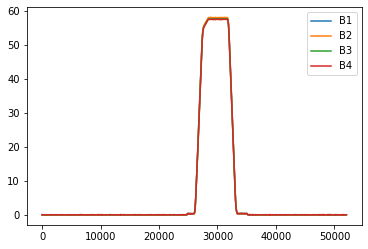

In [10]:
df.plot()

In [90]:
class AnimateBridge2D:
    
    def __init__(self, beam_length, angles, origin=(0,0)):
        
        self.len = beam_length
        self.angles = angles
        self.fig, self.ax = plt.subplots(figsize=(5,5))
        self.origin = origin
        self.beams = [self.make_beam() for _ in range(4)]
        self.colors = ["red", "blue", "green", "orange"]
    
    def make_beam(self):
        b0 = LineString([self.origin, (self.len, 0)])
        return b0
    
    def init(self):
    
        x0, y0 = np.array(self.beams[0].coords.xy)
        beam_plot = self.ax.plot(x0,y0, color='blue')

        self.ax.set_xlabel("x")
        self.ax.set_label("y")
        self.ax.grid()

    def update(self, i):
        self.ax.cla()
        i = int(i)
        current_angles = self.angles[i,:] ## Current angle
        
        for j, curr_ang in enumerate(current_angles):   
            b1 = affinity.rotate(self.beams[j], angle=curr_ang, origin=self.origin)
            x1,y1 = np.array(b1.coords.xy)
            self.ax.plot(x1, y1, color=self.colors[j], label=f"Beam {j+1}: {curr_ang:.4f}")
            self.ax.legend(title="Beam rotations:", fancybox=True, loc="upper left")
            self.ax.set_ylim(0,self.len)
            self.ax.set_xlim(0,self.len)
            self.ax.axis("off")
                        
        return self.ax 
    
    def animate(self, interval=300, frames=None):
        if frames is None:
            frames = np.arange(len(self.angles))
            
        ani = animation.FuncAnimation(self.fig, self.update, frames=frames, init_func=self.init, interval=interval)
        plt.close()
        return HTML(ani.to_jshtml())

In [91]:
%%time
AnimateBridge2D(beam_length=0.001, angles = df.values).animate(interval=300, frames=10)

Wall time: 436 ms


In [36]:
angles = df.iloc[0,:]


B1    0.061267
B2    0.026058
B3    0.049594
B4    0.058805
Name: 0, dtype: float64

In [100]:
class AnimateStats:
    
    '''
    Animate the rotation of all the beams of a bridge
    '''
    
    def __init__(self, angles, beam_length):
        
        self.angles = angles
        self.fig, self.ax = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
        # construct beams:
        self.len = beam_length
        self.beams = [self.make_beam() for _ in range(4)]
                
        self.colors = ["red", "blue", "green", "orange"]
        
    def make_beam(self):
        b0 = LineString([(0,0), (self.len, 0)])
        return b0
        
    def init(self):
        pass

    def update(self, i):
        
        i = int(i)
        current_angles = self.angles[i,:] ## Current angle
        
        self.ax[1].cla()
        bp = 0.01 ## Bar plot constant
        norm_angles = current_angles-current_angles.min() + bp
        min_a, max_a = norm_angles.min(), norm_angles.max()

        self.ax[1].bar([f"Beam {x}" for x in range(4)], norm_angles, color=self.colors, width=0.5)        

        rects = self.ax[1].patches
        for i,(norm_ang, ang, rect) in enumerate(zip(norm_angles, current_angles, rects)):
            height = rect.get_height()
            self.ax[1].text(x=i,y=height*1.05, s=f"{ang:.4f}" + u"\N{DEGREE SIGN}", horizontalalignment='center', fontsize=12)
        self.ax[1].set_xlabel("beam rotation")
        self.ax[1].set_label("angle")
        self.ax[1].set_yticks([], [])         

        for side in ["left", "right", "top"]:   
            self.ax[1].spines[side].set_visible(False)
        
        ## Animate the beams:
        self.ax[0].cla()
        for j, curr_ang in enumerate(current_angles):   
            b1 = affinity.rotate(self.beams[j], angle=curr_ang, origin=(0,0))
            x1,y1 = np.array(b1.coords.xy)
            self.ax[0].plot(x1, y1, color=self.colors[j], label=f"Beam {j+1}: {curr_ang:.4f}" + u"\N{DEGREE SIGN}")
            self.ax[0].legend(title="Beam rotations:", loc="upper left")
            self.ax[0].set_ylim(0,self.len)
            self.ax[0].set_xlim(0,self.len)
            self.ax[0].axis("off")
        
        
        return self.fig 
    
    def animate(self, interval=300, frames=None):
        if frames is None:
            frames = np.arange(len(self.angles))
            
        ani = animation.FuncAnimation(self.fig, self.update, frames=frames, init_func=self.init, interval=interval)
        plt.close()
        return ani

anim = AnimateStats(angles = df.values, beam_length=1).animate(interval=300, frames=10)
HTML(anim.to_jshtml())

In [98]:
%%time
## Exporting the video:
writervideo = animation.FFMpegWriter(fps=1)
anim.save(filename="video.mp4", writer=writervideo, dpi=300)

Wall time: 3min 3s
